<a href="https://colab.research.google.com/github/EatingLupini/QuantumCircuitEvaluation/blob/main/QuantumCircuitEvaluation_Example_Carry_Select_Adder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cirq --quiet
!pip install projectq --quiet

In [2]:
import cirq
import numpy as np
from cirq.contrib.svg import SVGCircuit

from projectq import MainEngine
from projectq.backends import CircuitDrawer
from projectq.ops import *

In [3]:
class CircuitEvaluation:
  def __init__(self):
    # Build circuit
    self.circuit = cirq.Circuit()
    # Get a simulator
    self.sim = cirq.Simulator()
    # Qubit map
    self.qubits = dict()
    #Gates Weight
    self.gates_weight = {
        "X": 1,
        "CNOT": 2,
        "TOFFOLI": 4,
        "FREDKIN": 4
        }
    # Qubits order
    self.qubits_order = list()
    # Result labels
    self.result_labels = list()

    # Optimization
    self.same_values = list()
    self.default_values = dict()

    # ProjectQ
    self.drawing_engine = CircuitDrawer()
    self.main_engine = MainEngine(engine_list=[self.drawing_engine])
    # ProjectQ Qubit map
    self.pq_qubits = dict()


  # Add new qubit to the circuit
  def add_qubit(self, name):
    new_qubit = cirq.NamedQubit(name)
    self.qubits[name] = new_qubit
    self.qubits_order.append(new_qubit)
    self.pq_qubits[name] = self.main_engine.allocate_qubit()  # projectQ


  # Add new qubits to the circuit
  def add_qubits(self, names, same_val, def_val):
    for name in names:
      self.add_qubit(name)
    self.same_values = same_val
    self.default_values = def_val
  

  # Add one or more gates to the circuit
  def add_ops(self, *ops):
    self.circuit.append(ops)
  

  # Finalize the circuit and add the measurement gate
  def finalize(self, measurement_order=None, result_map=None):
    if measurement_order is not None:
      self.qubits_order = [self.qubits[m] for m in measurement_order]
    if result_map is not None:
      self.result_labels = result_map
    else:
      self.result_labels = [qb.name for qb in self.qubits_order]
    self.circuit.append([cirq.measure(self.qubits_order, key='result')])
    self.main_engine.flush()  # projectQ


  # Set gates weight
  def set_gates_weight(self, weights):
    self.gates_weight = weights


  # Return the produced circuit
  def get_circuit(self):
    return self.circuit
  

  # Draw the circuit
  def draw(self):
    return SVGCircuit(self.circuit)
  

  # Print stat
  def print_stat(self, text, val):
    nchars = 25
    stat_space = " " * (nchars - len(text))
    stat_val = str(val)
    print(text + stat_space + stat_val)


  # Print the stats of the circuit (number of qubit)
  def print_stats(self):
    print("STATS")

    # Number of qubits
    self.print_stat("Number of qubits:", len(self.qubits))

    # Number of gates
    num_gates_all = 0
    num_gates = dict()
    for moment in self.circuit.moments:
      for op in moment.operations:
        if "MeasurementGate" not in str(op.gate):
          num_gates_all += 1
          if op.gate in num_gates:
            num_gates[op.gate] += 1
          else:
            num_gates[op.gate] = 1
    self.print_stat("Number of gates (All):", num_gates_all)

    # Number of gates per type
    for gate in num_gates.keys():
      self.print_stat(f"  {gate}:", num_gates[gate])

    # Depth (len - 1 because of the measurement gate)
    self.print_stat("Circuit depth:", len(self.circuit.moments) - 1)

    # Depth with weights
    depth_full = 0
    for moment in self.circuit.moments:
      max_w = 1
      all_measurements = True
      for op in moment.operations:
        if str(op.gate) in self.gates_weight:
          max_w = max(max_w, self.gates_weight[str(op.gate)])
          all_measurements = False
      if all_measurements:
        max_w = 0
      depth_full += max_w
    self.print_stat("Circuit weighted depth:", depth_full)
  

  # Beautify results
  def print_results(self, full_data):
    qbs_len = list()
    res_len = list()

    txt_cols = "|"
    for qb in self.qubits_order:
      qbs_len.append(len(qb.name))
      txt_cols += qb.name + "|"
    txt_cols += "  ->  |"
    for name in self.result_labels:
      res_len.append(len(name))
      txt_cols += name + "|"
    
    print("." + "_" * (len(txt_cols) - 2) + ".")
    print(txt_cols)

    txt_sep = "|"
    for qbl in qbs_len:
      txt_sep += "=" * qbl + "|"
    txt_sep += "  ->  |"
    for rl in res_len:
      txt_sep += "=" * rl + "|"

    print(txt_sep)

    for data in full_data:
      qbs, res = data
      txt_row = "|"
      for i in range(len(qbs)):
        qb, qbl = str(qbs[i]), qbs_len[i]
        txt_row += qb + " " * (qbl - len(qb)) + "|"
      txt_row += "  ->  |"
      for i in range(len(res)):
        rv, rl = str(res[i]), res_len[i]
        txt_row += rv + " " * (rl - len(rv)) + "|"
      print(txt_row)
    print("*" + "=" * (len(txt_cols) - 2) + "*")


  # Run a simulation and return
  def simulate(self, qb_state, draw=True):
    qb_state_dec = 0
    for b in qb_state:
        qb_state_dec = 2 * qb_state_dec + b
    result = self.sim.simulate(self.circuit,
                          qubit_order=self.qubits_order,
                          initial_state=qb_state_dec)
    if draw:
      self.print_results([(qb_state, result.measurements['result'])])
    return result


  # Run a simulation for each input
  def simulate_all(self, draw=True):
    full_data = list()
    num_qubits = len(self.qubits_order)
    num_comb = 2 ** num_qubits
    for current_val in range(num_comb):
      temp_str_state = format(current_val, f'0{num_qubits}b')
      temp_qb_state = [int(c) for c in temp_str_state]
      
      # check
      skip = False

      # check default values
      for i in range(num_qubits):
        cur_qb_name = self.qubits_order[i].name
        cur_qb_value = temp_qb_state[i]
        if cur_qb_name not in self.default_values or \
          cur_qb_value == self.default_values[cur_qb_name]:
          continue
        skip = True
      
      # check same values
      if not skip:
        sv = dict()
        for i in range(num_qubits):
          cur_qb_name = self.qubits_order[i].name
          cur_qb_value = temp_qb_state[i]
          for same in self.same_values:
            if cur_qb_name in same:
              if same in sv:
                if cur_qb_value != sv[same]:
                  skip = True
                  break
              else:
                sv[same] = cur_qb_value
          if skip:
            break

      if skip:
        continue
      
      res = self.simulate(temp_qb_state, False)
      full_data.append((temp_qb_state, res.measurements['result']))
    if draw:
      self.print_results(full_data)
    return full_data
  

  # Print latex
  def print_latex(self, lst_in, lst_out):
    latex_txt = self.drawing_engine.get_latex()
    lines = latex_txt.splitlines()
    
    max_x = 0
    for line_index in range(len(lines)):
      line = lines[line_index]
      if '\\node' in line:
        cur_x = float(line[line.rfind("(")+1:line.rfind(",")])
        if cur_x > max_x:
          max_x = cur_x
      if '\\node[none]' in line:
        num_wire = int(line[line.rfind("-")+1:line.rfind(")")])
        check_valid = line[line.rfind("{")+1:line.rfind("}")]
        if check_valid:
          txt_cur = line[line.rfind("{")-5:line.rfind("}")]
          txt_new = "$\\Ket{" + lst_in[num_wire] + "}$"
          lines[line_index] = line.replace(txt_cur, txt_new)
    
    for i in range(len(lst_out)):
      wire = lst_out[i]
      si = str(i)
      smx = str(max_x + 1)
      lines.insert(len(lines)-2,
          "\\node[none] (line" + si + "_gate999) at (" + smx + ",-" + si + ") {$\\Ket{" + wire + "}$};")
      lines.insert(len(lines)-2,
          "\\draw (line" + si + "_gate0) edge[edgestyle] (line" + si + "_gate999);")
    
    latex_edited = ""
    for line in lines:
      latex_edited += line + "\n"
    
    print(latex_edited)


  # bind gates
  def X(self, *qbs):
    X | self.pq_qubits[qbs[0]]
    return cirq.X(self.qubits[qbs[0]])
  def CNOT(self, *qbs):
    CNOT | (self.pq_qubits[qbs[0]], self.pq_qubits[qbs[1]])
    return cirq.CNOT(self.qubits[qbs[0]], self.qubits[qbs[1]])
  def TOFFOLI(self, *qbs):
    Toffoli | (self.pq_qubits[qbs[0]], self.pq_qubits[qbs[1]], self.pq_qubits[qbs[2]])
    return cirq.TOFFOLI(self.qubits[qbs[0]], self.qubits[qbs[1]], self.qubits[qbs[2]])
  def FREDKIN(self, *qbs):
    C(Swap) | (self.pq_qubits[qbs[0]], self.pq_qubits[qbs[1]], self.pq_qubits[qbs[2]])
    return cirq.FREDKIN(self.qubits[qbs[0]], self.qubits[qbs[1]], self.qubits[qbs[2]])


In [4]:
# Circuit
ce = CircuitEvaluation()

# Qubits
ce.add_qubits(["cin", "b0", "a0", "b1", "a1", "anc0_0",
                "b2_0", "a2_0", "anc0_1", "b3_0", "a3_0", "anc0_2",
                "b2_1", "a2_1", "b3_1", "a3_1", "anc0_3"],
              [("anc0_0", "anc0_1", "anc0_2", "anc0_3"),
                ("b2_0", "b2_1"), ("a2_0", "a2_1"),
                ("b3_0", "b3_1"), ("a3_0", "a3_1")],
              {"anc0_0": 0})

# Gates
ce.add_ops(ce.CNOT("a0", "b0"), ce.CNOT("a1", "b1"), ce.CNOT("a3_0", "b3_0"),
            ce.CNOT("b2_1", "a2_1"), ce.CNOT("a3_1", "b3_1"))
ce.add_ops(ce.CNOT("a0", "cin"), ce.CNOT("a3_0", "anc0_1"),
            ce.CNOT("a3_1", "a2_1"))
ce.add_ops(ce.CNOT("a1", "a0"), ce.TOFFOLI("b2_0", "a2_0", "anc0_1"),
            ce.CNOT("a3_0", "anc0_2"), ce.CNOT("a3_1", "anc0_3"))
ce.add_ops(ce.TOFFOLI("cin", "b0", "a0"), ce.CNOT("a1", "anc0_0"),
            ce.TOFFOLI("anc0_1", "b3_0", "anc0_2"),
            ce.TOFFOLI("a2_1", "b3_1", "anc0_3"))
ce.add_ops(ce.X("b0"), ce.TOFFOLI("a0", "b1", "anc0_0"),
            ce.CNOT("anc0_1", "b3_0"), ce.CNOT("a2_1", "b3_1"))
ce.add_ops(ce.CNOT("cin", "b0"), ce.CNOT("a0", "b1"),
            ce.CNOT("a3_0", "anc0_1"), ce.CNOT("a3_1", "a2_1"))
ce.add_ops(ce.TOFFOLI("cin", "b0", "a0"),ce.TOFFOLI("b2_0", "a2_0", "anc0_1"),
            ce.CNOT("a3_0", "b3_0"), ce.CNOT("b2_1", "a2_1"),
            ce.CNOT("a3_1", "b3_1"))
ce.add_ops(ce.X("b0"), ce.CNOT("a1", "a0"), ce.CNOT("a2_0", "b2_0"),
            ce.X("b2_1"))
ce.add_ops(ce.CNOT("a0", "cin"), ce.CNOT("a1", "b1"), ce.CNOT("a2_1", "b2_1"))
ce.add_ops(ce.CNOT("a0", "b0"))
ce.add_ops(ce.FREDKIN("anc0_0", "anc0_2", "anc0_3"))
ce.add_ops(ce.FREDKIN("anc0_0", "b2_0", "b2_1"))
ce.add_ops(ce.FREDKIN("anc0_0", "b3_0", "b3_1"))

# Finalize
ce.finalize(["cin", "b0", "a0", "b1", "a1", "anc0_0",
                "b2_0", "a2_0", "anc0_1", "b3_0", "a3_0", "anc0_2",
                "b2_1", "a2_1", "b3_1", "a3_1", "anc0_3"],
            ["cin", "s0", "a0", "s1", "a1", "c2",
                "s2", "a2", "0", "s3", "a3", "s4",
                "-", "a2", "-", "a3", "-"])

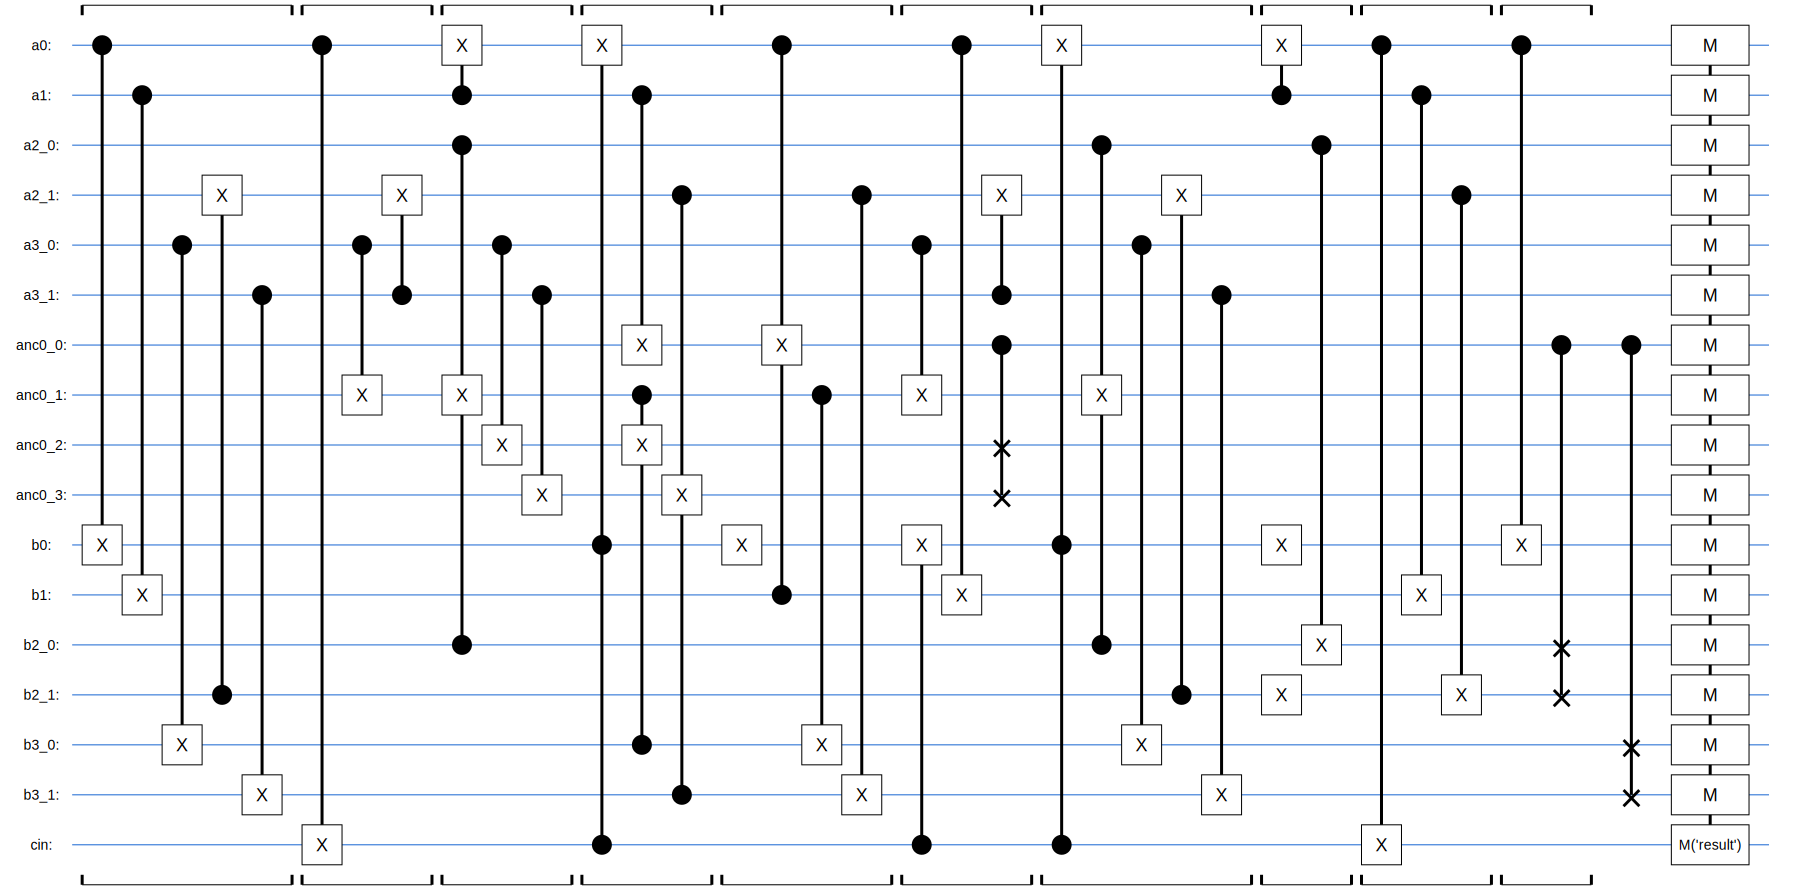

In [5]:
# Draw circuit
ce.draw()

In [6]:
ce.print_stats()

STATS
Number of qubits:        17
Number of gates (All):   40
  CNOT:                  27
  TOFFOLI:               7
  X:                     3
  FREDKIN:               3
Circuit depth:           11
Circuit weighted depth:  36


In [7]:
# "cin", "b0", "a0", "b1", "a1", "anc0_0", "b2_0", "a2_0", "anc0_1", "b3_0", "a3_0", "anc0_2", "b2_1", "a2_1", "b3_1", "a3_1", "anc0_3" ->
# "cin", "s0", "a0", "s1", "a1", "c2", "s2", "a2", "0", "s3", "a3", "s4", "-", "a2", "-", "a3", "-"
# 0001
# 0111
# 1000
res = ce.simulate([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0])

.__________________________________________________________________________________________________________________________________________.
|cin|b0|a0|b1|a1|anc0_0|b2_0|a2_0|anc0_1|b3_0|a3_0|anc0_2|b2_1|a2_1|b3_1|a3_1|anc0_3|  ->  |cin|s0|a0|s1|a1|c2|s2|a2|0|s3|a3|s4|-|a2|-|a3|-|
|===|==|==|==|==|======|====|====|======|====|====|======|====|====|====|====|======|  ->  |===|==|==|==|==|==|==|==|=|==|==|==|=|==|=|==|=|
|0  |1 |1 |0 |1 |0     |0   |1   |0     |0   |0   |0     |0   |1   |0   |0   |0     |  ->  |0  |0 |1 |0 |1 |1 |0 |1 |0|1 |0 |0 |1|1 |0|0 |0|
*==========================================================================================================================================*


In [8]:
res = ce.simulate_all()

.__________________________________________________________________________________________________________________________________________.
|cin|b0|a0|b1|a1|anc0_0|b2_0|a2_0|anc0_1|b3_0|a3_0|anc0_2|b2_1|a2_1|b3_1|a3_1|anc0_3|  ->  |cin|s0|a0|s1|a1|c2|s2|a2|0|s3|a3|s4|-|a2|-|a3|-|
|===|==|==|==|==|======|====|====|======|====|====|======|====|====|====|====|======|  ->  |===|==|==|==|==|==|==|==|=|==|==|==|=|==|=|==|=|
|0  |0 |0 |0 |0 |0     |0   |0   |0     |0   |0   |0     |0   |0   |0   |0   |0     |  ->  |0  |0 |0 |0 |0 |0 |0 |0 |0|0 |0 |0 |1|0 |0|0 |0|
|0  |0 |0 |0 |0 |0     |0   |0   |0     |0   |1   |0     |0   |0   |0   |1   |0     |  ->  |0  |0 |0 |0 |0 |0 |0 |0 |0|1 |1 |0 |1|0 |1|1 |0|
|0  |0 |0 |0 |0 |0     |0   |0   |0     |1   |0   |0     |0   |0   |1   |0   |0     |  ->  |0  |0 |0 |0 |0 |0 |0 |0 |0|1 |0 |0 |1|0 |1|0 |0|
|0  |0 |0 |0 |0 |0     |0   |0   |0     |1   |1   |0     |0   |0   |1   |1   |0     |  ->  |0  |0 |0 |0 |0 |0 |0 |0 |0|0 |1 |1 |1|0 |0|1 |1|
|0  |0 |0 |0 

In [9]:
# verify results
def verify_results(stop=True):
  for row in res:
    current_ret = (row, False)

    ri = row[0]
    str_a = f'{ri[10]}{ri[7]}{ri[4]}{ri[2]}'
    str_b = f'{ri[9]}{ri[6]}{ri[3]}{ri[1]}'
    int_a = int(str_a, 2)
    int_b = int(str_b, 2)
    cin = ri[0]

    tot = int_a + int_b + cin
    str_tot = format(tot, f'05b')

    # sum
    ro = row[1]
    check_result = [11, 9, 6, 3, 1]
    for i in range(len(check_result)):
      if int(str_tot[i]) != ro[check_result[i]]:
        print("Sum is not correct:")
        print(f" {str_a} ({int_a}) a")
        print(f" {str_b} ({int_b}) b")
        print(f" 000{cin} ({cin}) cin")
        print(f"{ro[check_result[0]]}{ro[check_result[1]]}{ro[check_result[2]]}{ro[check_result[3]]}{ro[check_result[4]]} sum")
        print(f"It should be: {str_tot}\n\n")
        if stop:
          return current_ret
        else:
          break

    # cin
    if ri[0] != ro[0]:
      print("Cin has changed")
      if stop:
        return current_ret
    
    # 0
    if ro[8] != 0:
      print("The wire 0 is not 0")
      if stop:
        return current_ret
    
    # a
    check_result = [2, 4, 7, 10]
    for i in range(len(check_result)):
      if ri[check_result[i]] != ro[check_result[i]]:
        print("a is different:")
        print(f"{ri[check_result[0]]}{ri[check_result[1]]}{ri[check_result[2]]}{ri[check_result[3]]}{ri[check_result[4]]} input")
        print(f"{ro[check_result[0]]}{ro[check_result[1]]}{ro[check_result[2]]}{ro[check_result[3]]}{ro[check_result[4]]} output")
        if stop:
          return current_ret
        else:
          break

  return None, True


ver_res, ver_passed = verify_results(False)
if ver_passed:
  print("Passed!")
else:
  print("Test Failed!")
  # print(ver_res)


Sum is not correct:
 0110 (6) a
 0110 (6) b
 0000 (0) cin
00100 sum
It should be: 01100


Sum is not correct:
 1110 (14) a
 0110 (6) b
 0000 (0) cin
01100 sum
It should be: 10100


Sum is not correct:
 0110 (6) a
 1110 (14) b
 0000 (0) cin
01100 sum
It should be: 10100


Sum is not correct:
 1110 (14) a
 1110 (14) b
 0000 (0) cin
10100 sum
It should be: 11100


Sum is not correct:
 0111 (7) a
 0110 (6) b
 0000 (0) cin
00101 sum
It should be: 01101


Sum is not correct:
 1111 (15) a
 0110 (6) b
 0000 (0) cin
01101 sum
It should be: 10101


Sum is not correct:
 0111 (7) a
 1110 (14) b
 0000 (0) cin
01101 sum
It should be: 10101


Sum is not correct:
 1111 (15) a
 1110 (14) b
 0000 (0) cin
10101 sum
It should be: 11101


Sum is not correct:
 0110 (6) a
 0111 (7) b
 0000 (0) cin
00101 sum
It should be: 01101


Sum is not correct:
 1110 (14) a
 0111 (7) b
 0000 (0) cin
01101 sum
It should be: 10101


Sum is not correct:
 0110 (6) a
 1111 (15) b
 0000 (0) cin
01101 sum
It should be: 10101




In [10]:
# PASTE HERE:
# https://latex.net/texlive/

ce.print_latex(["c_{in}", "b_0", "a_0", "b_1", "a_1", "0",
                "b_2", "a_2", "0", "b_3", "a_3", "0",
                "b_2", "a_2", "b_3", "a_3", "0"], 
              ["c_{in}", "s_0", "a_0", "s_1", "a_1", "c_2",
                "s_2", "a_2", "0", "s_3", "a_3", "s_4",
                "", "a_2", "", "a_3", ""])

\documentclass{standalone}
\usepackage[margin=1in]{geometry}
\usepackage[hang,small,bf]{caption}
\usepackage{tikz}
\usepackage{braket}
\usetikzlibrary{backgrounds,shadows.blur,fit,decorations.pathreplacing,shapes}

\begin{document}
\begin{tikzpicture}[scale=0.8, transform shape]

\tikzstyle{basicshadow}=[blur shadow={shadow blur steps=8, shadow xshift=0.7pt, shadow yshift=-0.7pt, shadow scale=1.02}]\tikzstyle{basic}=[draw,fill=white,basicshadow]
\tikzstyle{operator}=[basic,minimum size=1.5em]
\tikzstyle{phase}=[fill=black,shape=circle,minimum size=0.1cm,inner sep=0pt,outer sep=0pt,draw=black]
\tikzstyle{none}=[inner sep=0pt,outer sep=-.5pt,minimum height=0.5cm+1pt]
\tikzstyle{measure}=[operator,inner sep=0pt,minimum height=0.5cm, minimum width=0.75cm]
\tikzstyle{xstyle}=[circle,basic,minimum height=0.35cm,minimum width=0.35cm,inner sep=-1pt,very thin]
\tikzset{
shadowed/.style={preaction={transform canvas={shift={(0.5pt,-0.5pt)}}, draw=gray, opacity=0.4}},
}
\tikzstyle{swapstyle}=[inne